# [실습01] MLP - 행렬곱 구현




## 1. 라이브러리 임포트 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 지금은 torch를 이용하기보다 행렬과 벡터 단위에서 구현 
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms

## 2. MNIST test dataset 가져오기

In [2]:
mnist_test = dset.MNIST("", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

## 3. 대략적인 데이터 형태

mnist_test 길이 :  10000
image data 형태 :  torch.Size([1, 28, 28])
label :  7


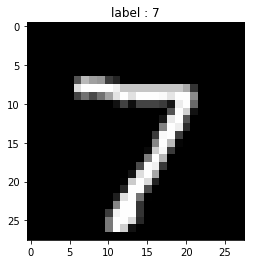

In [3]:
print "mnist_test 길이 : ", len(mnist_test)

# 데이터 하나 형태
image, label = mnist_test.__getitem__(0) # 0번째 데이터!
print "image data 형태 : ", image.size()
print "label : ", label

# 그리기
img = image.numpy() # image 타입을 numpy 형태로 변환 ( 1, 28, 28)
plt.title("label : %d" %label)
plt.imshow(img[0], cmap="gray")
plt.show()

## 4. sigmoid, softmax 함수 구현

 $$ g(z) = { 1 \over 1 + e^{-z} } $$

In [4]:
# mlp 설계에서 사용하게 될 시그모이드 함수
# for문을 이용하지 않고 내부적으로 최적화된 함수 쓰기 -> GPU 가속 받기 ex) numpy
# x = z
def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

 $$ softmax(x)_i = { e^xi \over \sum_j{e^{x_j}} } $$

In [5]:
# mlp 설계에서 사용하게 될 소프트맥스 함수
def softmax(x) : 
    e_x = np.exp(x)
    return e_x / np.sum(e_x)

## 5. 모델 선언

In [6]:
# multi-layered perceptron 
# # of units in each layer : 28 * 28 - 258 - 128 - 10

class MyMLP:
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output): # input layer의 개수, 히든레이어12, output 유닛의 개수를 입력 받음 
        # W^(1) : layer1 -> layer2에 매핑되는 가중치
        # b : bias
        
        # (n_hidden1, n_input)만큼 공간을 만들 건데 0으로 채워줘
        self.W1 = np.zeros( (n_hidden1, n_input), dtype=np.float32 ) #W1(258, 28*28)
        self.b1 = np.zeros( (n_hidden1, ), dtype = np.float32 )
        
        self.W2 = np.zeros( (n_hidden2, n_hidden1), dtype=np.float32 ) # W2(128, 128)
        self.b2 = np.zeros( (n_hidden2, ), dtype =np.float32 )
        
        self.W3 = np.zeros( (n_output, n_hidden2), dtype=np.float32 ) # W3(10, 128)
        self.b3 = np.zeros( (n_output), dtype =np.float32 )
        
        # 여기까지 클래스의 객체가 선언되자마자 불러지는 생성자! 
    
    # class의 객체를 생성하고 객체에 입력값 x를 넣으면 자동으로 불려짐 
    def __call__(self, x):
        # ( 1, 28, 28) -> ( 28 * 28) 
        x = x.reshape(-1) # 우리는 2차원 데이터 받으니까 일렬로 펴기
        
        h1 = sigmoid( np.dot(self.W1, x) + self.b1 ) # W1(258, 28*28), x(28 * 28), b1(258) -> h1(256) => w1*x + b1
        # 요즘은 sigmoid보다 Relu나 LeakyReLU 주로 씀 
        # sigmoid가 제안 되었을 때는 feature가 한 두 개 일 때~
        h2 = np.dot(self.W2, h1) + self.b2 # W2(128, 256), h1(256), b2(128) -> h2(128) => w2*h1 + b2
        out = np.dot(self.W3, h2) + self.b3 # W3(10, 128), h2(128), b3(10) -> out(10) => w3*h2 + b3
        
        return softmax(out) # (10) -> 0부터 1 사이 10개 unit들의 값을 모두 합치면 1이 되도록 

## 6. 모델 생성

In [7]:
# 객체 생성
model = MyMLP(28*28, 256, 128, 10)

In [8]:
print model.W1.shape, model.b1.shape
print model.W2.shape, model.b2.shape
print model.W3.shape, model.b3.shape

(256, 784) (256,)
(128, 256) (128,)
(10, 128) (10,)


## 7. 미리 학습된 weight 로드

In [9]:
weights = np.load('./nets/mlp_weight.npz')

model.W1 = weights['W1']
model.b1 = weights['b1']
model.W2 = weights['W2']
model.b2 = weights['b2']
model.W3 = weights['W3']
model.b3 = weights['b3']

print model.W1.shape, model.b1.shape
print model.W2.shape, model.b2.shape
print model.W3.shape, model.b3.shape

(256, 784) (256,)
(128, 256) (128,)
(10, 128) (10,)


## 8. 테스트

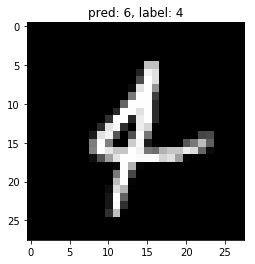

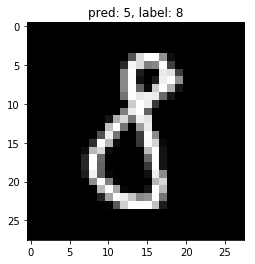

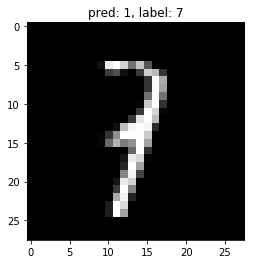

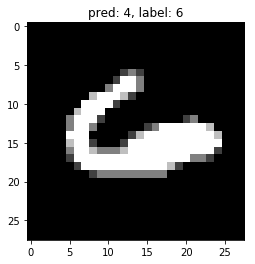

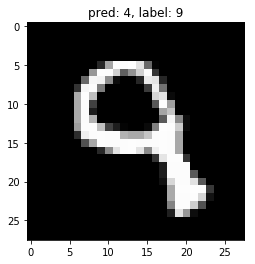

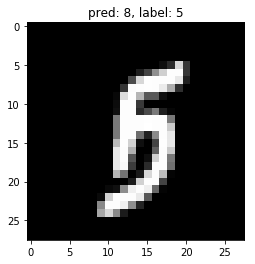

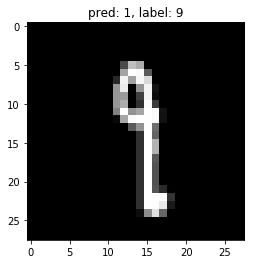

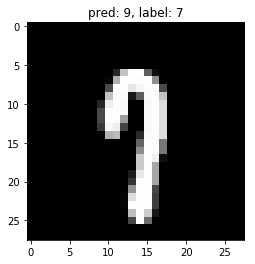

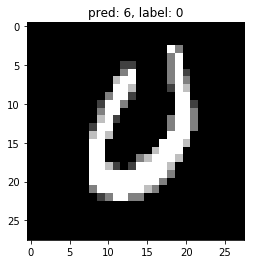

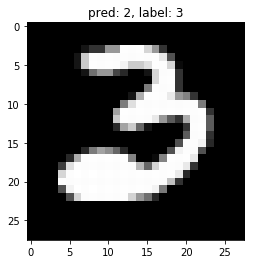

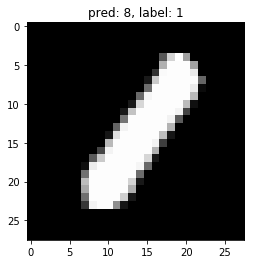

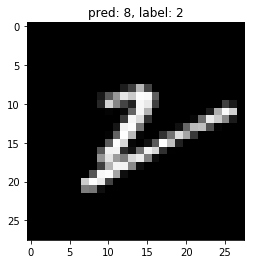

정확도 : 91.91


In [17]:
mysum = 0

# 데이터 길이 m을 구하고 데이터들을 돌며 이미지와 레이블을 구하며 생성된 모델에 이미지를 넣어줌
# call 함수로 output 레이어의 값을 output 변수에 받게됨
m = len(mnist_test)
cnt = 0

for i in range(m):
    image, label = mnist_test.__getitem__(i) # 0번째 데이터
    output = model(image)
    
#     if ( i % 1000 == 0 ):
#         img = image.numpy()
#         pred_label = np.argmax(output)
#         plt.title("pred: %d, label: %d" %(pred_label, label))
#         plt.imshow(img[0], cmap='gray')
#         plt.show()

    if ( i % 100 == 0 ):
        img = image.numpy()
        pred_label = np.argmax(output)
        # 예측한 label과 실제 label이 다른 이미지 출력 
        if ( pred_label != label ):
            plt.title("pred: %d, label: %d" %(pred_label, label))
            plt.imshow(img[0], cmap='gray')
            plt.show()
    
    cnt += 1
    mysum += (np.argmax(output) == label) # output은 원핫인코딩(추정되는 값만 1로 만들고 나머지는 0으로) 방식으로 0부터 9까지 예측 
    # 각 원소의 값 중 가장 큰 값에 해당하는 유닛의 인덱스가 모델이 예측한 레이블이 됨-> max값에 해당하는 인덱스를 리턴하는 np.argmax 이용 

print "정확도 : %.2f" % ((float(mysum) / cnt) * 100.0) 